In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/prev-model/submission.csv
/kaggle/input/prev-model/trained_tokenizer/tokenizer.json
/kaggle/input/prev-model/trained_tokenizer/tokenizer_config.json
/kaggle/input/prev-model/trained_tokenizer/special_tokens_map.json
/kaggle/input/prev-model/results/checkpoint-1024/config.json
/kaggle/input/prev-model/results/checkpoint-1024/trainer_state.json
/kaggle/input/prev-model/results/checkpoint-1024/training_args.bin
/kaggle/input/prev-model/results/checkpoint-1024/scheduler.pt
/kaggle/input/prev-model/results/checkpoint-1024/model.safetensors
/kaggle/input/prev-model/results/checkpoint-1024/optimizer.pt
/kaggle/input/prev-model/results/checkpoint-1024/rng_state.pth
/kaggle/input/prev-model/results/checkpoint-500/config.json
/kaggle/input/prev-model/results/checkpoint-500/trainer_state.json
/kaggle/input/prev-model/results/checkpoint-500/training_args.bin
/kaggle/input/prev-model/results/checkpoint-500/scheduler.pt
/kaggle

# **IMPORT**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from collections import Counter
from itertools import chain

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import (
    PreTrainedTokenizerFast,
    Trainer, 
    TrainingArguments,
    DistilBertForSequenceClassification, 
    DistilBertConfig
)
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from scipy.sparse import vstack as spvstack
from scipy.special import softmax

In [3]:
class BPETokenizer:
    ST = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.tok = Tokenizer(models.BPE(unk_token="[UNK]"))
        self.tok.normalizer = normalizers.Sequence([normalizers.NFC()])
        self.tok.pre_tokenizer = pre_tokenizers.ByteLevel()
        self.tok.post_processor = processors.TemplateProcessing(
            single="[CLS] $A",
            special_tokens=[("[CLS]", 1)],
        )
        
    @classmethod
    def chunk_dataset(cls, dataset, chunk_size=1_000):
        for i in range(0, len(dataset), chunk_size):
            yield dataset[i : i + chunk_size]["text"]
        
    def train(self, data):
        trainer = trainers.BpeTrainer(vocab_size=self.vocab_size, special_tokens=self.ST)
        dataset = Dataset.from_pandas(data[["text"]])
        self.tok.train_from_iterator(self.chunk_dataset(dataset), trainer=trainer)
        return self
    
    def tokenize(self, data):
        tokenized_texts = []
        for text in tqdm(data['text'].tolist()):
            tokenized_texts.append(self.tok.encode(text))
        return tokenized_texts
    
    def get_fast_tokenizer(self, max_length):
        return PreTrainedTokenizerFast(
            tokenizer_object=self.tok,
            unk_token="[UNK]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            sep_token="[SEP]",
            mask_token="[MASK]",
            model_max_length=max_length
        )
    
    
class DAIGTDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data, labels = None):
        self.tokenized_data = tokenized_data
        if labels is not None:
            self.labels = labels
        else:
            self.labels = np.zeros(self.tokenized_data.input_ids.shape[0], dtype="int")
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_data.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return self.labels.shape[0]
    
    @classmethod
    def create_tokenized_dataset(cls, tknzr, df):
        tokenized_data = tknzr(
            df.text.tolist(), 
            max_length=tknzr.model_max_length, 
            padding="max_length", 
            return_tensors="pt",
            truncation=True
        )
        if "label" in df:
            labels = df.label.values
        else:
            labels = None
        return cls(tokenized_data, labels=labels)
    
    
def compute_roc_auc(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    if labels.std() < 1E-8: # only one class present in dataset
        return {"roc_auc": 0.0}
    ps = softmax(logits, axis=-1)[:,1]
    return {"roc_auc": roc_auc_score(labels, ps)}

Use the AI-generated community data to provide more prompts and the AI-generated stuff. 
(daigt-v2-train-dataset)

In [4]:
train = pd.read_csv(
    "/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"
)
test = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
# could sample for class balance, specific prompts etc
sampled_train = train.query("RDizzl3_seven").reset_index(drop=True)

Train your own tokenizer

In [5]:
word_counter = Counter()
for _, _t in tqdm(train.text.items(), total=len(train)):
    word_counter.update(_t.strip().split())

100%|██████████| 44868/44868 [00:02<00:00, 15716.08it/s]


In [6]:
print(f"Total unique space-separated 'words' = {len(word_counter):,}")
word_counter.most_common(10)

Total unique space-separated 'words' = 178,016


[('the', 694050),
 ('to', 620741),
 ('and', 476006),
 ('a', 411352),
 ('of', 351893),
 ('that', 254313),
 ('in', 244448),
 ('is', 243376),
 ('be', 179836),
 ('for', 168205)]

In [7]:
%%time
bpe_tok = BPETokenizer(10_000).train(
    pd.concat((train, test)).reset_index(drop=True)
)




CPU times: user 1min 6s, sys: 1.68 s, total: 1min 7s
Wall time: 18.7 s


**DistilBert classifier**

How this differs from the Keras team's approach:

training a much smaller model, but with
a bigger context window, so we can encode the vast majority of every essay (not just the first 512 tokens).

In [8]:
seq_length = 2048
tokenizer = bpe_tok.get_fast_tokenizer(seq_length)
db_config = DistilBertConfig(
    vocab_size=tokenizer.vocab_size,
    max_position_embeddings=seq_length,
    n_layers=3,
    n_heads=4,
    pad_token_id=tokenizer.pad_token_id
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
%%time
tr_df, val_df = train_test_split(sampled_train, random_state=113, test_size=0.2)

sl = slice(None) # DEBUGGING: slice(16, 32)

train_dataset = DAIGTDataset.create_tokenized_dataset(tokenizer, tr_df[sl])
val_dataset = DAIGTDataset.create_tokenized_dataset(tokenizer, val_df[sl])

print(f"train size = {len(train_dataset)}, validation size = {len(val_dataset)}")

train size = 16360, validation size = 4090
CPU times: user 1min 4s, sys: 4.37 s, total: 1min 9s
Wall time: 35.8 s


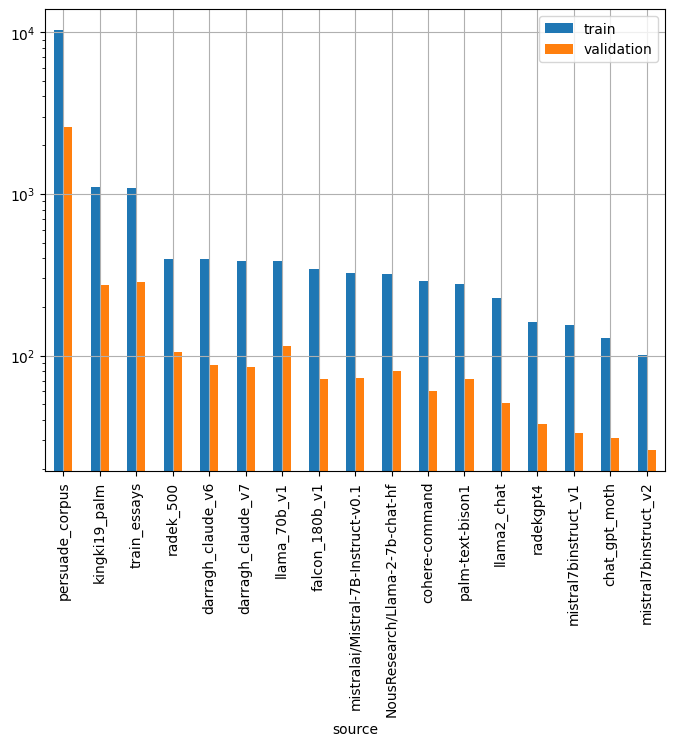

In [10]:
norm_ = False
pd.concat((
    tr_df.source.value_counts(normalize=norm_).rename("train"),
    val_df.source.value_counts(normalize=norm_).rename("validation")
), axis=1).plot.bar(figsize=(8, 6))
if not norm_:
    plt.yscale("log")
plt.grid()
plt.show()


In [11]:
db_model = DistilBertForSequenceClassification(db_config)
training_args = TrainingArguments(
    output_dir="results",          # output directory
    num_train_epochs=2,              # total number of training epochs
    # max_steps=11,
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir="logs",            # directory for storing logs
    logging_steps=100,
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
)
trainer = Trainer(
    model=db_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_roc_auc,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Transformer Prediction
Get the final prediction on the test set, using the same trainer interface.

In [20]:
%%time
test_dataset = DAIGTDataset.create_tokenized_dataset(tokenizer, test)
test_predictions = trainer.predict(test_dataset)
p_db = softmax(test_predictions.predictions, axis=-1)[:, 1]
p_db

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


CPU times: user 953 ms, sys: 630 ms, total: 1.58 s
Wall time: 1.62 s


array([0.4731816 , 0.48802206, 0.48686263], dtype=float32)

Submission¶st

In [21]:
test["generated"] = p_db
test

,id,prompt_id,text,generated
0,0000aaaa,2,Aaa bbb ccc.,0.473182
1,1111bbbb,3,Bbb ccc ddd.,0.488022
2,2222cccc,4,CCC ddd eee.,0.486863


In [15]:
import torch
from transformers import pipeline

In [16]:
def predict_ai_generated(text, model, tokenizer, device='cuda'):
    """
    Predicts whether the input text is AI-generated or not using the trained DistilBERT model.
    
    Parameters:
    - text: str, the input text to predict
    - model: the trained DistilBERT model (DistilBertForSequenceClassification)
    - tokenizer: the trained tokenizer (PreTrainedTokenizerFast)
    - device: str, device to run the model on ('cuda' for GPU, 'cpu' for CPU)
    
    Returns:
    - prediction: float, probability that the text is AI-generated (class 1)
    """
    
    # Tokenize the input text
    inputs = tokenizer(
        text, 
        padding=True, 
        truncation=True, 
        max_length=tokenizer.model_max_length, 
        return_tensors="pt"
    )
    
    # Remove 'token_type_ids' if present (DistilBERT doesn't require them)
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
    
    # Move tensors to the desired device (GPU or CPU)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Ensure the model is in evaluation mode
    model.eval()

    # Make predictions using the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    # Get the probability for the AI-generated class (class 1)
    ai_generated_prob = probabilities[0, 1].item()

    return ai_generated_prob

In [44]:
# Example usage:
input_text = "a ball is rolling down the hill"
prediction = predict_ai_generated(input_text, db_model, tokenizer, device='cuda')

print(f"Probability that the text is AI-generated: {prediction:.4f}")

Probability that the text is AI-generated: 0.0001


In [22]:
# Save the trained model and its configuration
db_model.save_pretrained('/kaggle/working/trained_model')

In [23]:
tokenizer.save_pretrained('/kaggle/working/trained_tokenizer')

('/kaggle/working/trained_tokenizer/tokenizer_config.json',
 '/kaggle/working/trained_tokenizer/special_tokens_map.json',
 '/kaggle/working/trained_tokenizer/tokenizer.json')

LOADING MODEL

In [24]:
# from transformers import DistilBertForSequenceClassification, PreTrainedTokenizerFast
# import torch

# # Load the trained model and tokenizer
# model = DistilBertForSequenceClassification.from_pretrained('/kaggle/working/final_trained_model')
# tokenizer = PreTrainedTokenizerFast.from_pretrained('/kaggle/working/final_trained_tokenizer')

# # Ensure that the model is in evaluation mode (important for inference)
# model.eval()

Now you can use the predict_ai_generated text again

In [33]:
# Example usage:
input_text = "Artificial Intelligence (AI) is no longer a concept confined to the realm of science fiction; it is an integral part of our everyday lives"
prediction = predict_ai_generated(input_text, db_model, tokenizer, device='cuda')

print(f"Probability that the text is AI-generated: {prediction:.4f}")

Probability that the text is AI-generated: 0.0003


In [32]:
input_text = "The advent of social media has revolutionized the way we connect, communicate, and consume information. While it offers numerous benefits, such as facilitating global interactions and knowledge sharing, it also has a significant impact on our mental health. The constant exposure to curated and often idealized versions of reality can lead to feelings of inadequacy, social comparison, and negative self-perception."
# Choose the device (cuda if available, else cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the correct device
db_model.to(device)

# Call the prediction function
prediction = predict_ai_generated(input_text, db_model, tokenizer, device)

print(f"Probability that the text is AI-generated: {prediction:.4f}")



Probability that the text is AI-generated: 1.0000


In [27]:
test[["id", "generated"]].to_csv("submission.csv", index=False)


In [28]:
import shutil

# Create a tarball (zip) of the model directory for easy downloading
shutil.make_archive("/kaggle/working/final_trained_model_archive", 'zip', '/kaggle/working/final_trained_model')
shutil.make_archive("/kaggle/working/final_trained_tokenizer_archive", 'zip', '/kaggle/working/final_trained_tokenizer')

'/kaggle/working/final_trained_tokenizer_archive.zip'

In [29]:
# import zipfile

# # Unzip the model and tokenizer files
# with zipfile.ZipFile('/kaggle/input/final_trained_model_archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/kaggle/working/final_trained_model')

# with zipfile.ZipFile('/kaggle/input/final_trained_tokenizer_archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/kaggle/working/final_trained_tokenizer')


In [30]:
from transformers import DistilBertForSequenceClassification, PreTrainedTokenizerFast
import torch

# Load the trained model and tokenizer from the new paths
db_model = DistilBertForSequenceClassification.from_pretrained('/kaggle/input/prev-model/results/checkpoint-1000')  # Update to the desired checkpoint
tokenizer = PreTrainedTokenizerFast.from_pretrained('/kaggle/input/prev-model/trained_tokenizer')

# Ensure that the model is in evaluation mode (important for inference)
db_model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(10000, 768, padding_idx=1)
      (position_embeddings): Embedding(2048, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-2): 3 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [13]:
db_model = DistilBertForSequenceClassification.from_pretrained('/kaggle/input/prev-model/trained_model')